masih ada duplikat di bulan 11/12

In [2]:
import utils
import pandas as pd
import calendar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# 1
# open files
arr = utils.fileList("rsc/")
arr.sort()
lists = list()
unused_columns = ['nilai_kerugian',
'jumlah_tempat_pengungsian',
'jumlah_pengungsi_tertinggi',
'jumlah_luka_ringan',
'jumlah_luka_berat',
'jumlah_hilang',
'jumlah_meninggal',
'lama_genangan',
'ketinggian_air',
'jumlah_terdampak_jiwa',
'jumlah_terdampak_kk',
'jumlah_terdampak_rw',
'jumlah_terdampak_rt',
'rw']
for item in arr:
    csv = utils.readCsv("rsc/" + item)
    for unused in unused_columns:
        csv.drop(unused, axis=1, inplace=True)
    csv.drop_duplicates(subset=None, keep='first', inplace=False)
    lists.append(csv)

In [5]:
# 3
nama_benahan = ["PULOGADUNG", "CILIINCING", "MAMPANG"]
for bulan in lists:
    for i in range(len(nama_benahan)):
        if i == 0:
            bulan.loc[bulan['kecamatan'] == nama_benahan[i], 'kecamatan'] = "PULO GADUNG"
        elif i == 1:
            bulan.loc[bulan['kecamatan'] == nama_benahan[i], 'kecamatan'] = "CILINCING"
        elif i == 2:
            bulan.loc[bulan['kecamatan'] == nama_benahan[i], 'kecamatan'] = "MAMPANG PRAPATAN"

In [6]:
# 4
loc = [10,11]
for l in loc:
    rows = lists[l]['tanggal_kejadian']
    for row in rows:
        if "-" in row:
            dd = str(row[-2:])
            lists[l].loc[lists[l]['tanggal_kejadian'] == row, 'tanggal_kejadian'] = dd
        

In [7]:
# 5
# normalize table in tanggal_kejadian column
data_normaliasi_tanggal = list()
# re.search(r'[0-9]{2}, txt')

def ubah_format(kata : str) -> str:
    if len(kata) == 1:
        return "0"+kata
    else:
        return kata



for bulan in lists:
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].str.split(',')
    bulan = bulan.explode('tanggal_kejadian').reset_index(drop=True)
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: kalimat.replace("tgl. ", ""))
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: kalimat.lstrip()[:2])
    bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: ubah_format(kalimat))

    

    # bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat: kalimat.ljust(2, '0'))
    # bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].apply(lambda kalimat.string(): re.search(r'[0-9]{2}', kalimat))
    # bulan['tanggal_kejadian'] = bulan['tanggal_kejadian'].str.extract('(\d+)', expand=False)
    data_normaliasi_tanggal.append(bulan)


In [8]:
for bulan in data_normaliasi_tanggal:
    bulan.drop_duplicates()

In [9]:
# 6
# Membersihkan Data

for month in data_normaliasi_tanggal:
    month.drop_duplicates(subset=[
        'kota_administrasi', 
        'kecamatan', 
        'kelurahan', 
        'tanggal_kejadian'], 
        keep='first', 
        inplace=True
        )


In [10]:
# 7
# making a dictionary of kelurahan, where kecamatan : [kelurahan]
kecamatan = list()
kelurahan = dict()
for bulan in data_normaliasi_tanggal:
    kecamatan_bulan_n = bulan['kecamatan'].drop_duplicates()
    for i in kecamatan_bulan_n:
        if i not in kecamatan:
            kecamatan.append(i)
    num = int()
    for enum, kec in enumerate(kecamatan_bulan_n):
        kelurahan[kec] = list(bulan.loc[bulan['kecamatan'] == kec, 'kelurahan'].drop_duplicates())

In [11]:
# 8
total = int()
for val in kelurahan.values():
    total += len(val)
# print(total)

In [12]:
# for enum, kel in enumerate(kelurahan, 1):
#     print("bulan " + str(calendar.month_name[enum]))
#     for kec in kecamatan:
#         print("kecamatan : " + kec)
#         print("kelurahan : " + ", ".join(kelurahan[kec]))
#         print("_________")
        

In [13]:
# 9
# kasus banjir per-kelurahan
kasus_banjir_per_bulan = list()
banjir_per_kelurahan = dict()
for bulan in data_normaliasi_tanggal: 
    for kec in kecamatan:
        for kel in kelurahan[kec]:
            kejadian = len(bulan[bulan['kelurahan'] == kel])
            # print(kel + " " + str(kejadian))
            banjir_per_kelurahan[kel] = kejadian
    banjir_per_kelurahan = pd.Series(banjir_per_kelurahan).reset_index()
    banjir_per_kelurahan.columns = ['kelurahan', 'kejadian']
    kasus_banjir_per_bulan.append(banjir_per_kelurahan)
    banjir_per_kelurahan = dict()

In [14]:
print(kasus_banjir_per_bulan[11].nlargest(5, "kejadian"))

         kelurahan  kejadian
58  KAMPUNG MELAYU         2
26    KEDOYA UTARA         1
27       SRENGSENG         1
42   PEJATEN TIMUR         1
59     BIDARA CINA         1


In [15]:
kasus_banjir_per_bulan_kecamatan = list()

In [16]:
for setiap_bulan in kasus_banjir_per_bulan:
    kasus_banjir_bulan_n_kecamatan = dict()
    for kec in kecamatan:
        total = int()
        kels = kelurahan[kec]
        for kel in kels:
            total += setiap_bulan.loc[setiap_bulan['kelurahan'] == kel, 'kejadian'].values[0]
        kasus_banjir_bulan_n_kecamatan[kec] = total
    banjir = pd.Series(kasus_banjir_bulan_n_kecamatan).reset_index()
    banjir.columns = ['kecamatan', 'kejadian']
    kasus_banjir_per_bulan_kecamatan.append(banjir)


In [17]:
for setiap_bulan in kasus_banjir_per_bulan_kecamatan:
    print(setiap_bulan.nlargest(10, 'kejadian'))

         kecamatan  kejadian
31         MAKASAR         8
7      PENJARINGAN         7
15        CILANDAK         5
29      JATINEGARA         5
18  KEBAYORAN LAMA         4
20        PANCORAN         4
22    PESANGGRAHAN         4
26        CIPAYUNG         4
4        CILINCING         3
5    KELAPA GADING         3
      kecamatan  kejadian
29   JATINEGARA        14
30  KRAMAT JATI        13
31      MAKASAR        13
25       CAKUNG        12
9    CENGKARENG        10
26     CIPAYUNG        10
1     KEMAYORAN         9
7   PENJARINGAN         9
11    KALIDERES         9
2   SAWAH BESAR         7
         kecamatan  kejadian
29      JATINEGARA        18
30     KRAMAT JATI        13
18  KEBAYORAN LAMA         9
21    PASAR MINGGU         6
31         MAKASAR         4
22    PESANGGRAHAN         3
24           TEBET         3
7      PENJARINGAN         2
15        CILANDAK         2
20        PANCORAN         2
           kecamatan  kejadian
29        JATINEGARA         5
31           M

In [18]:
total_per_bulan = dict()
for enum, setiap_bulan in enumerate(kasus_banjir_per_bulan_kecamatan, 1):
    temp = sum(setiap_bulan['kejadian'])
    total_per_bulan[calendar.month_name[enum]] = temp


In [19]:
print(total_per_bulan)

{'January': 80, 'February': 177, 'March': 69, 'April': 40, 'May': 22, 'June': 28, 'July': 4, 'August': 8, 'September': 23, 'October': 90, 'November': 30, 'December': 10}


In [20]:
total_per_bulan = pd.Series(total_per_bulan).reset_index()
total_per_bulan.columns = ['bulan', 'kejadian']

In [21]:
def printBarPlot(df, column1, column2, color=True):

    df_filtered = df[df[column2] != 0]

    df_sorted = df_filtered.sort_values(column2)

    if color:
        min_value = df_sorted[column2].min()
        max_value = df_sorted[column2].max()

        norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
        color_map = plt.cm.get_cmap('viridis')

        plt.figure(figsize=(10, 6))
        plt.bar(df_sorted[column1], df_sorted[column2], color=color_map(norm(df_sorted[column2])))

        sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
        cbar = plt.colorbar(sm)
        cbar.set_label(column2)
        
    else:
        plt.figure(figsize=(10, 6))
        plt.bar(df_sorted[column1], df_sorted[column2])

    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.xticks(rotation='vertical')
    plt.show()

In [22]:
def printBarPlot2(df, column1, column2):
    
    month_order = [month for month in calendar.month_name if month != '']
    month_order = [month.capitalize() for month in month_order]

    df_sorted = df.iloc[df[column1].map(lambda x: month_order.index(x.capitalize())).argsort()]

    df_sorted= df_sorted[df_sorted[column2] != 0]


    plt.figure(figsize=(10, 6))
    plt.bar(df_sorted[column1], df_sorted[column2])


    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.xticks(rotation='vertical')
    plt.show()

In [23]:

def printBarPlot3(column1, column2, monthList, *dfs):
    num_plots = min(len(dfs), 6)
    rows = min(num_plots, 3)
    cols = math.ceil(num_plots / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    fig.suptitle('Kasus Banjir Jakarta pada Musim Hujan', fontsize=14)

    for i, df in enumerate(dfs[:num_plots]):
        row = i // cols
        col = i % cols
        ax = axes[row][col]

        df_filtered = df[df[column2] != 0]
        df_sorted = df_filtered.sort_values(column2)

        ax.bar(df_sorted[column1], df_sorted[column2])

        ax.set_ylabel(column2)
        ax.set_title(f'Bulan {calendar.month_name[monthList[i] + 1]}')
        ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically

    plt.tight_layout()
    plt.show()


C:\Users\ACER\AppData\Local\Temp\ipykernel_26380\1802849384.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


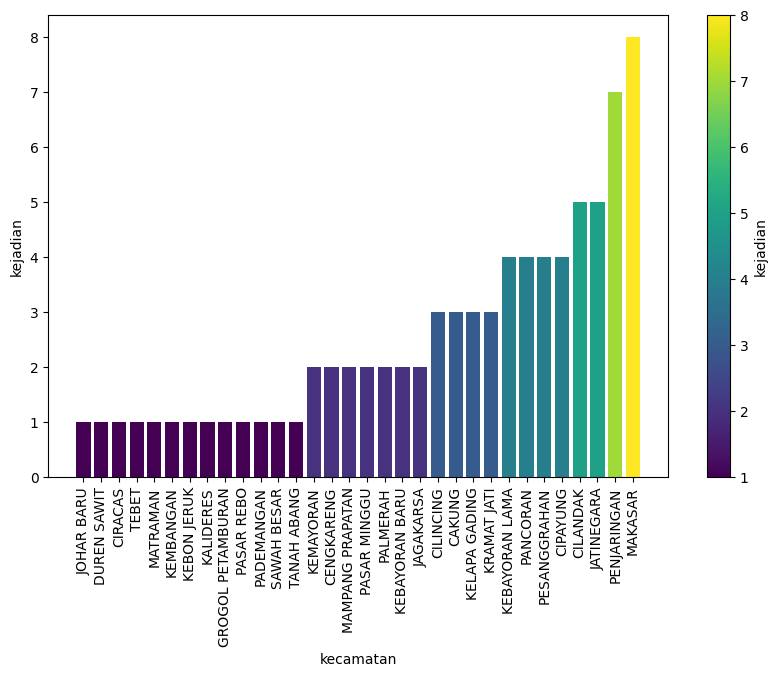

In [24]:
# 0 = januari
# 11 = desember
printBarPlot(kasus_banjir_per_bulan_kecamatan[0], 'kecamatan', 'kejadian')

In [25]:
kasus_banjir_pertahun_kecamatan = dict()
for kasus in kasus_banjir_per_bulan_kecamatan:
    kecam = kasus['kecamatan']
    for kec in kecam:
        try:
            kasus_banjir_pertahun_kecamatan[kec]
        except KeyError:
            kasus_banjir_pertahun_kecamatan[kec] = kasus.loc[kasus['kecamatan'] == kec, 'kejadian'].values[0]
        finally:
            kasus_banjir_pertahun_kecamatan[kec] += kasus.loc[kasus['kecamatan'] == kec, 'kejadian'].values[0]

In [26]:
print(kasus_banjir_pertahun_kecamatan)

{'JOHAR BARU': 5, 'KEMAYORAN': 13, 'SAWAH BESAR': 9, 'TANAH ABANG': 8, 'CILINCING': 22, 'KELAPA GADING': 13, 'KOJA': 3, 'PENJARINGAN': 44, 'PADEMANGAN': 7, 'CENGKARENG': 22, 'GROGOL PETAMBURAN': 9, 'KALIDERES': 17, 'KEBON JERUK': 9, 'KEMBANGAN': 9, 'PALMERAH': 8, 'CILANDAK': 20, 'JAGAKARSA': 12, 'KEBAYORAN BARU': 13, 'KEBAYORAN LAMA': 38, 'MAMPANG PRAPATAN': 23, 'PANCORAN': 26, 'PASAR MINGGU': 25, 'PESANGGRAHAN': 22, 'SETIABUDI': 2, 'TEBET': 21, 'CAKUNG': 22, 'CIPAYUNG': 29, 'CIRACAS': 7, 'DUREN SAWIT': 11, 'JATINEGARA': 67, 'KRAMAT JATI': 48, 'MAKASAR': 46, 'MATRAMAN': 5, 'PASAR REBO': 4, 'PULO GADUNG': 1, 'SENEN': 1, 'MENTENG': 4, 'CEMPAKA PUTIH': 3, 'GAMBIR': 1, 'TANJUNG PRIOK': 2, 'TAMAN SARI': 2, 'TAMBORA': 1, 'KEPULAUAN SERIBU SELATAN': 6, 'KEPULAUAN SERIBU UTARA': 1}


In [27]:
print(total_per_bulan)

        bulan  kejadian
0     January        80
1    February       177
2       March        69
3       April        40
4         May        22
5        June        28
6        July         4
7      August         8
8   September        23
9     October        90
10   November        30
11   December        10


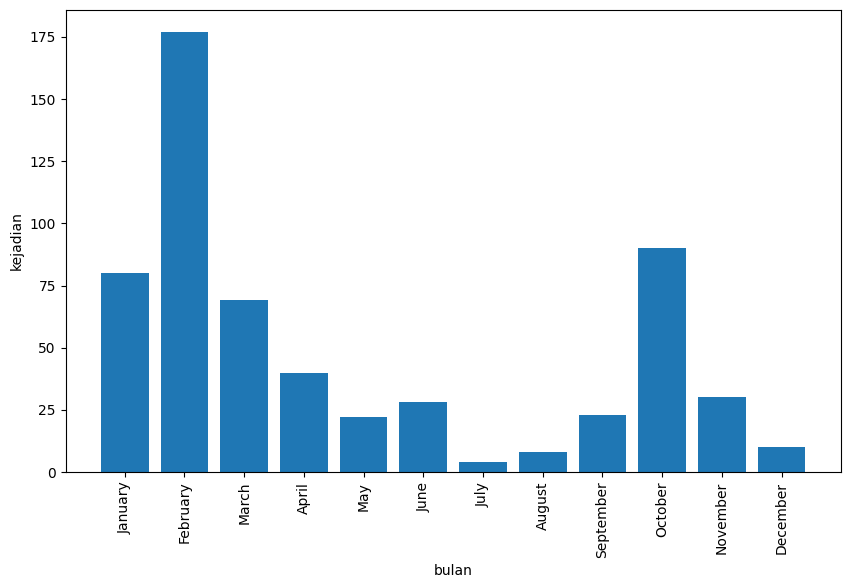

In [28]:
printBarPlot2(total_per_bulan, 'bulan', 'kejadian')

C:\Users\ACER\AppData\Local\Temp\ipykernel_26380\1532501795.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically
C:\Users\ACER\AppData\Local\Temp\ipykernel_26380\1532501795.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically
C:\Users\ACER\AppData\Local\Temp\ipykernel_26380\1532501795.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically
C:\Users\ACER\AppData\Local\Temp\ipykernel_26380\1532501795.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_sorted[column1], rotation='vertical')  # Rotating x-axis labels vertically
C:\Users\ACER\AppData\Local\Temp\ipy

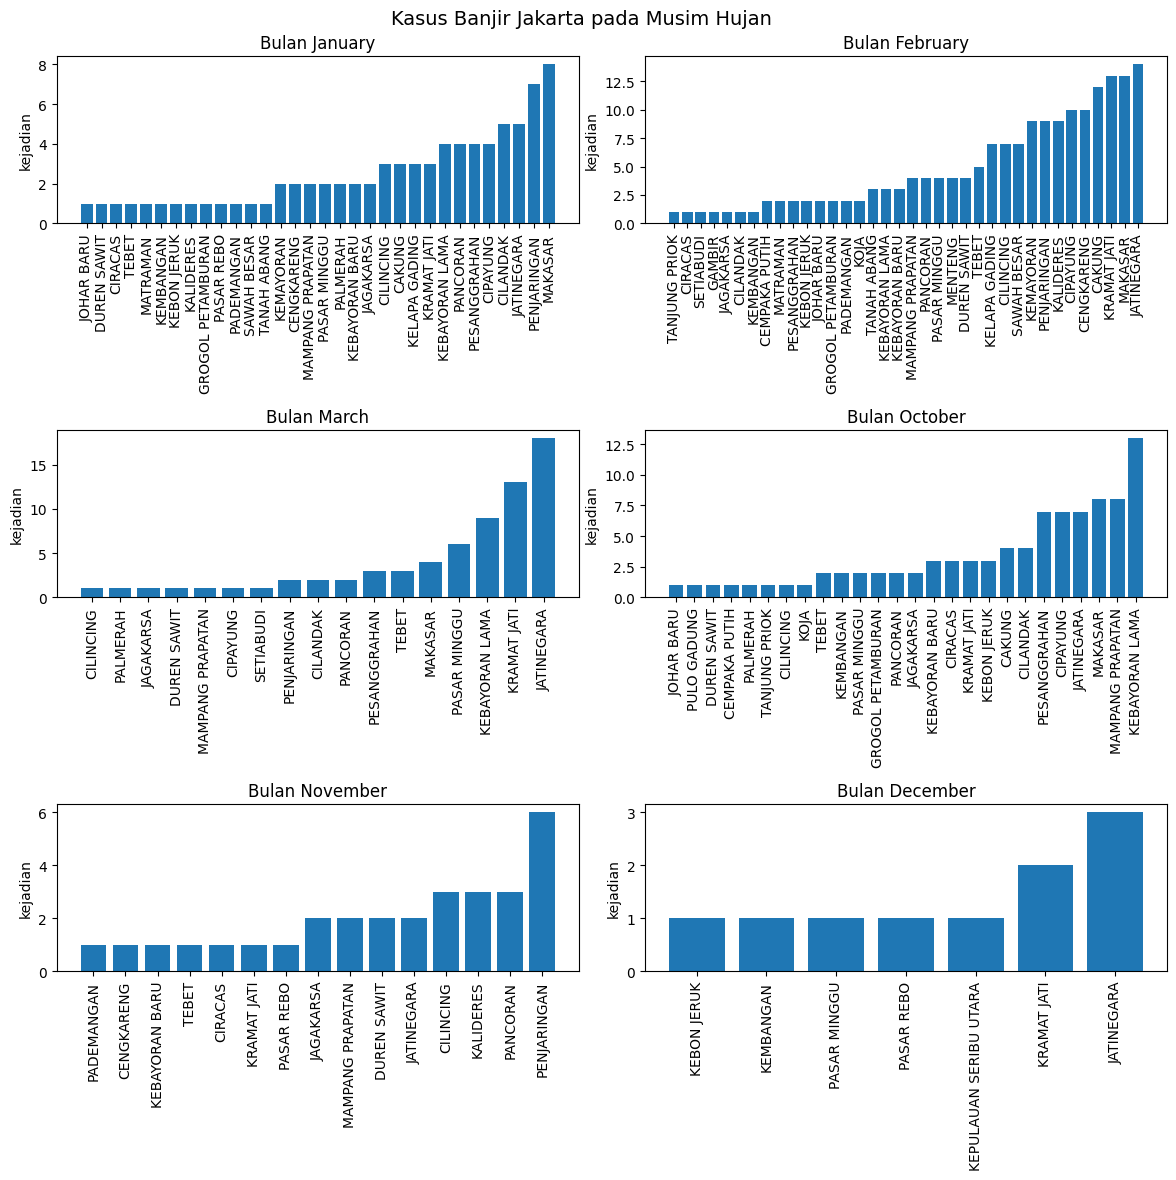

In [29]:
temp = list()
for _ in ([0,1,2,9,10,11]):
    temp.append(kasus_banjir_per_bulan_kecamatan[_])
printBarPlot3('kecamatan', 'kejadian',[0,1,2,9,10,11], *temp)

In [30]:
total_value_rainy_month = dict()
for k in temp:
    for row in k.itertuples():
        try:
            total_value_rainy_month[row.kecamatan]
        except KeyError:
            total_value_rainy_month[row.kecamatan] = row.kejadian
        finally:
            total_value_rainy_month[row.kecamatan] += row.kejadian


In [31]:
total_value_rainy_month = pd.Series(total_value_rainy_month).reset_index()
total_value_rainy_month.columns = ['kecamatan', 'total_kejadian']

C:\Users\ACER\AppData\Local\Temp\ipykernel_26380\1802849384.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


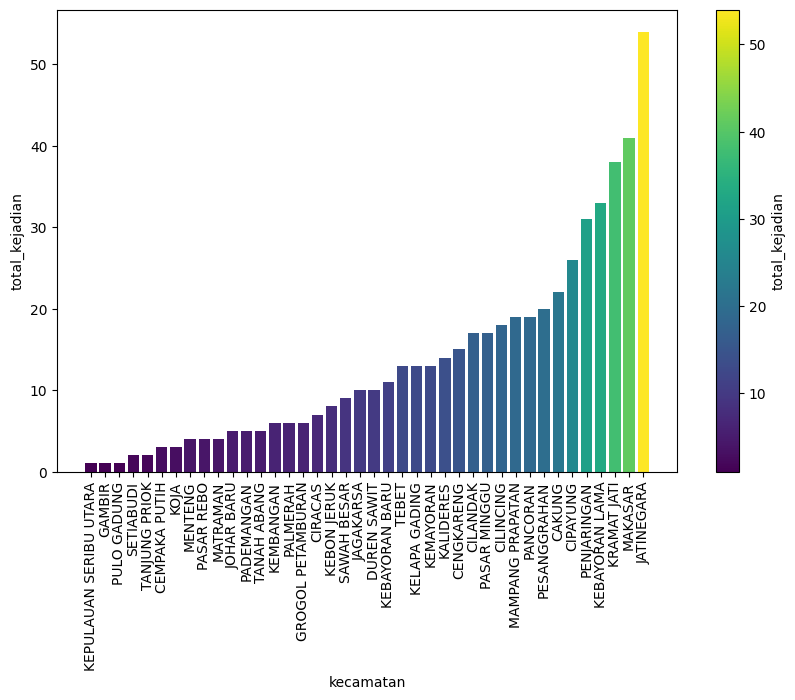

In [32]:

printBarPlot(total_value_rainy_month, 'kecamatan', 'total_kejadian')

In [33]:
jakarta_timur = ['CAKUNG','PULO GADUNG', 'JATINEGARA', 'MAKASAR', 'KRAMAT JATI', 'CIPAYUNG', 'CIRACAS', 'PASAR REBO', 'DUREN SAWIT']
jakarta_selatan = ['SETIABUDI', 'TEBET', 'PANCORAN', 'KEBAYORAN BARU', 'KEBAYORAN LAMA', 'PASAR MINGGU', 'JAGAKARSA', 'CILANDAK', 'MAMPANG PRAPATAN', 'PESANGGRAHAN']
jakarta_pusat = ['TANAH ABANG', 'MENTENG', 'GAMBIR', 'KEMAYORAN', 'SAWAH BESAR', 'SENEN', 'JOHAR BARU', 'CEMPAKA PUTIH', 'MATRAMAN']
jakarta_barat = ['KALIDERES', 'CENGKARENG', 'KEMBANGAN', 'KEBON JERUK', 'PALMERAH', 'GROGOL PETAMBURAN','TAMBORA', 'TAMAN SARI']
jakarta_utara = ['PENJARINGAN', 'PADEMANGAN', 'TANJUNG PRIOK', 'KOJA', 'KELAPA GADING', 'CILINCING']
kepulauan_seribu = ['KEPULAUAN SERIBU UTARA', 'KEPULAUAN SERIBU SELATAN']


In [34]:
j_timur_total = int()
j_selatan_total = int()
j_pusat_total = int()
j_barat_total = int()
j_utara_total = int()
k_seribu_total = int()

In [35]:
for index, row in total_value_rainy_month.iterrows():
    kec = row['kecamatan']
    if kec in jakarta_timur:
        j_timur_total += row['total_kejadian']
    elif kec in jakarta_selatan:
        j_selatan_total += row['total_kejadian']
    elif kec in jakarta_pusat:
        j_pusat_total += row['total_kejadian']
    elif kec in jakarta_barat:
        j_barat_total += row['total_kejadian']
    elif kec in jakarta_utara:
        j_utara_total += row['total_kejadian']
    elif kec in kepulauan_seribu:
        k_seribu_total += row['total_kejadian']
    else:
        print(kec + " " + str(row['total_kejadian']))
        print("not found")


In [36]:
total_per_bagian_jakarta = {"jakarta_timur": j_timur_total, "jakarta_selatan": j_selatan_total,
                            "jakarta_pusat": j_pusat_total, "jakarta_barat": j_barat_total, 
                            "jakarta_utara": j_utara_total, "kepulauan_seribu": k_seribu_total}
total_per_bagian_jakarta = pd.Series(total_per_bagian_jakarta).reset_index()
total_per_bagian_jakarta.columns = ['bagian_jakarta', 'total_kejadian']

In [37]:
print(total_per_bagian_jakarta)

     bagian_jakarta  total_kejadian
0     jakarta_timur             203
1   jakarta_selatan             161
2     jakarta_pusat              44
3     jakarta_barat              55
4     jakarta_utara              72
5  kepulauan_seribu               1


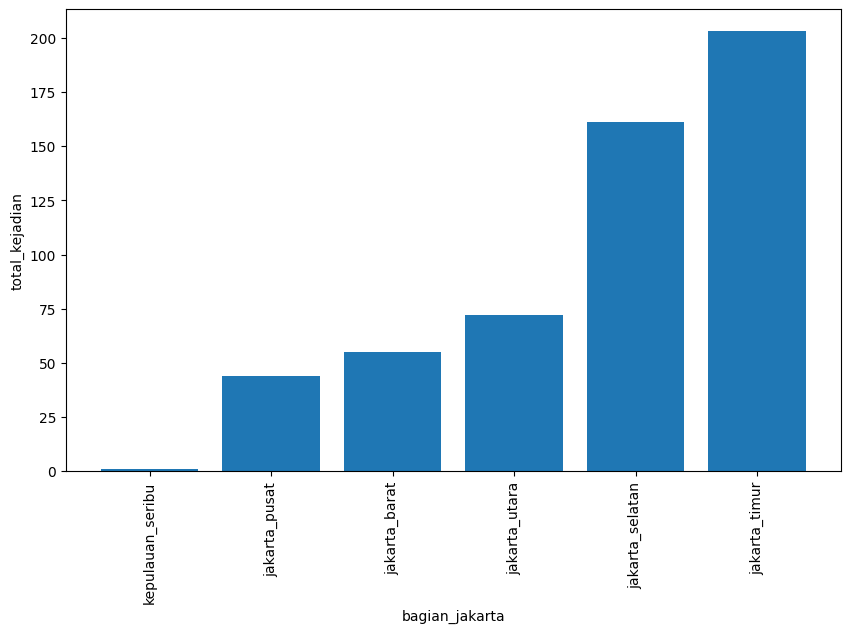

In [38]:
printBarPlot(total_per_bagian_jakarta,'bagian_jakarta', 'total_kejadian',False)

In [39]:
#https://data.jakarta.go.id/dataset/data-luas-daerah-dan-pembagian-daerah-administrasi-menurut-kota-administrasi-dki-jakarta/resource/541aabe7-84cc-447a-a5d1-0b90e7d09824
luas_daerah = utils.readCsv("luasdaerah.csv")
luas_daerah.drop('tahun', axis=1, inplace=True)
luas_daerah.drop('jumlah_kecamatan', axis=1, inplace=True)
luas_daerah.drop('jumlah_kelurahan', axis=1, inplace=True)


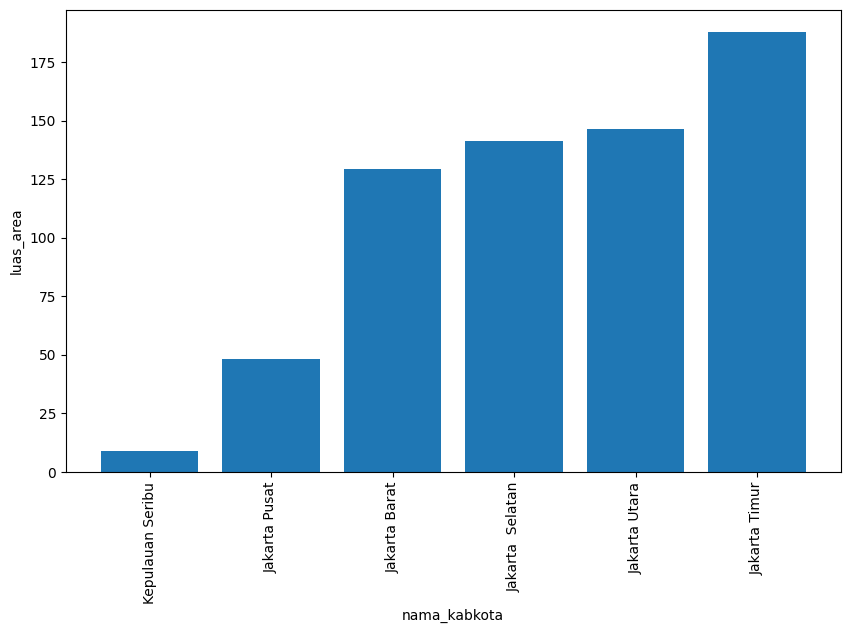

In [40]:
printBarPlot(luas_daerah, 'nama_kabkota', 'luas_area', False)

In [41]:
# https://jakarta.bps.go.id/indicator/12/124/1/penduduk-laju-pertumbuhan-penduduk-distribusi-persentase-penduduk-kepadatan-penduduk-rasio-jenis-kelamin-penduduk-menurut-provinsi-kabupaten-kota.html
kepadatan_penduduk = {"kepulauan_seribu": 2461.00,
"jakarta_selatan": 14664.00,
"jakarta_timur": 14390.00,
"jakarta_pusat": 18603.00,
"jakarta_barat": 17701.00,
"jakarta_utara": 11272.00,}
kepadatan_penduduk = pd.Series(kepadatan_penduduk).reset_index()
kepadatan_penduduk.columns = ['nama', 'kepadatan_penduduk']


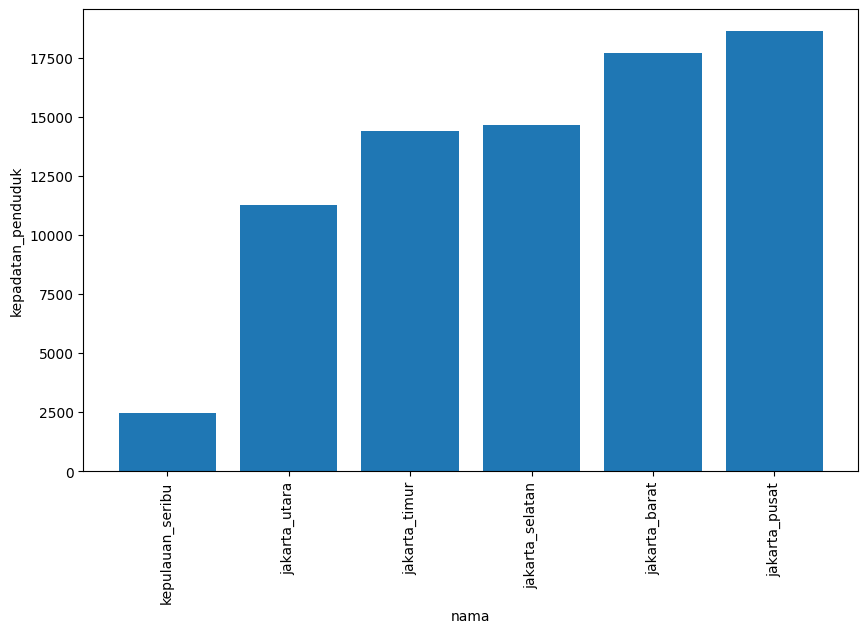

In [42]:
printBarPlot(kepadatan_penduduk, 'nama', 'kepadatan_penduduk', False)

In [43]:
#https://jakarta.bps.go.id/indicator/52/69/1/pdrb-perkapita.html
pendapatan_perkapita = { "kepulauan_seribu": 234079.00,
"jakarta_selatan": 289569.00,
"jakarta_timur": 155287.00,
"jakarta_pusat": 665829.00,
"jakarta_barat": 192975.00,
"jakarta_utara": 279767.00
}
pendapatan_perkapita = pd.Series(pendapatan_perkapita).reset_index()
pendapatan_perkapita.columns = ['nama', 'pendapatan_perkapita']

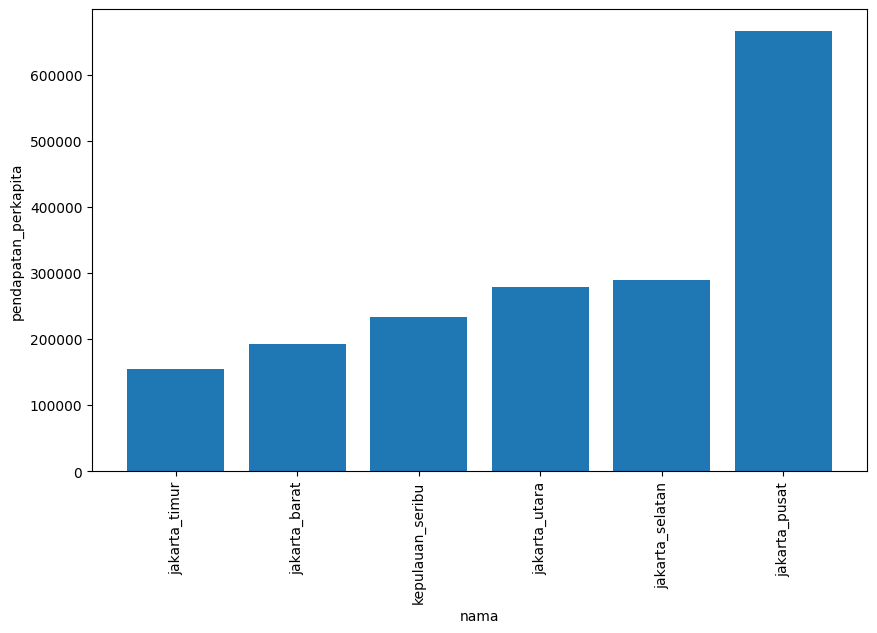

In [44]:
printBarPlot(pendapatan_perkapita, 'nama', 'pendapatan_perkapita', False)